In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
import operator
from IPython.display import clear_output
from scipy.signal import butter
from scipy.signal import sosfilt

L = 864/10**6   #enter approximate thickness of a substrate (in meters)
n_approx = 2    #enter approximate real refractive index of substrate

#paste below names of files with referent air signal, substrate signal, and substarte+film signal
f_name = ["/home/meriff/Python_projects/Experiment_graphene/Air.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Substrate.txt",
        "/home/meriff/Python_projects/Experiment_graphene/Graphene.txt"]

def count_rows(f_name):
    handle = open(f_name, "r")
    counter = 0
    for line in handle:
        counter += 1
    return counter

row_length = []
for name in f_name:
    row_length.append(count_rows(name))
T_length = min(row_length)

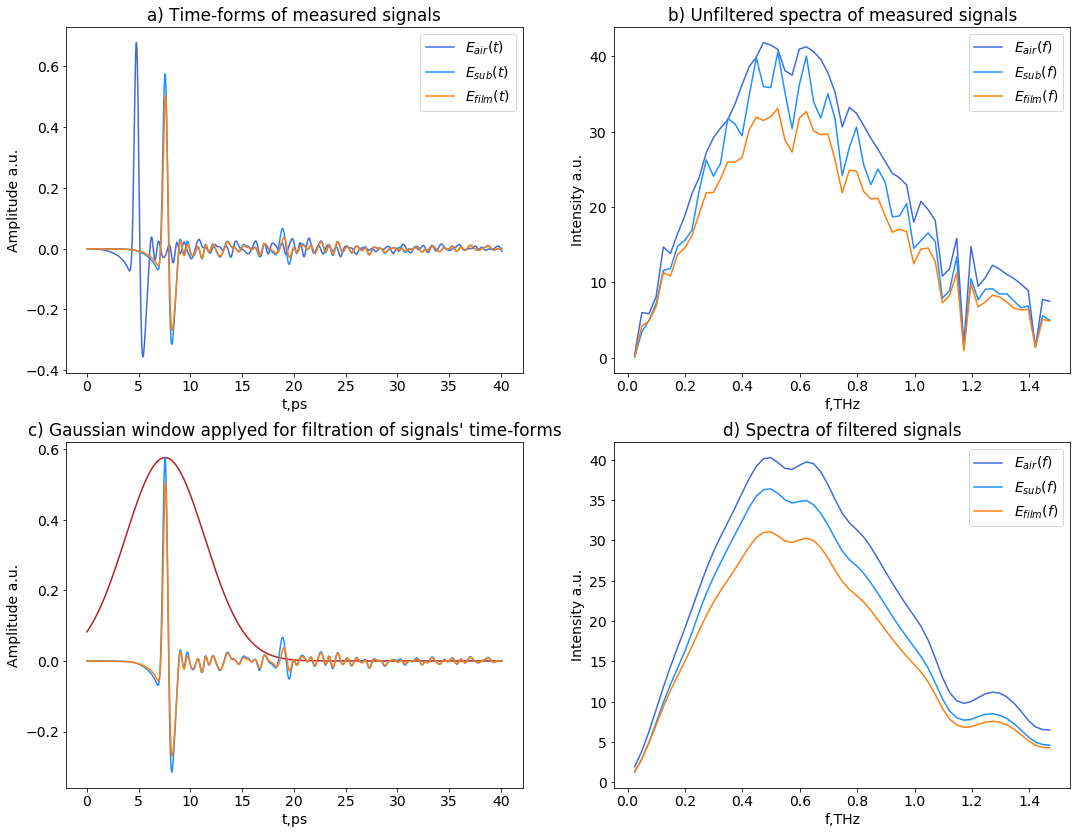

In [4]:
#enter border_stop  parameter, limiting the number of points in frequency-domain used for calculations
border_stop = 60

def read_info(f_name):
    handle = open(f_name, "r")
    data = []
    for line in handle:
        data.append([float(x) for x in line.split()])
    handle.close()
    timer_f=[]; signal_f=[]
    for i in range (0,T_length):
        timer_f.append(data[i][0])
        signal_f.append(data[i][1])
    return timer_f, signal_f

#function move_to_zero alligns the background signal to 0 u. (need to do as apparatus may apply non-zero voltage)
def move_to_zero(signal):
    average = 0
    for j in range (0,8):
        average = average + signal[j]/8
    for j in range (0,T_length):
        signal[j] = signal[j] - average
    return signal

Sequence = np.arange(0,T_length,1)

#function gauss_filter applies the gauss filtration to signal, cutting Fabri-Perot reflections from the time-form
def gauss_filter(signal,mid):
    for i in range (0,3):
        signal_gauss[i] = signal[i]*np.exp(-np.power((Sequence-mid[i]),2)/(2*gauss_sd**2))
    return(signal_gauss)

timer=np.zeros(T_length);   signal=np.zeros((3,T_length));   signal_gauss=np.zeros((3,T_length))
for i in range (0,3):
    timer,signal[i] = read_info(f_name[i])
    signal[i] = move_to_zero(signal[i])
    
dT = (timer[1] - timer[0])/10**12             #dT = step in time domain 
gauss_sd = int(2*L*n_approx/dT/(3*10**8)/3)
mid = np.zeros(3); max_value = np.zeros(3)
for i in range (0,3):
    mid[i], max_value[i] = max(enumerate(signal[i]), key=operator.itemgetter(1))
signal_gauss = gauss_filter(signal,mid)

frequency = np.fft.fftfreq(T_length, dT)      #array of frequences is generated
signal_w=np.fft.fft(signal,axis=1)
signal_w_gauss=np.fft.fft(signal_gauss,axis=1)

plt.rcParams['figure.figsize'] = [18,14]
plt.rc('font', size=14)

plt.subplot(2, 2, 1)
plt.plot(timer[0:T_length], signal[0,0:T_length], 'royalblue', label = '$E_{air}(t)$')
plt.plot(timer[0:T_length], signal[1,0:T_length], 'dodgerblue', label = '$E_{sub}(t)$')
plt.plot(timer[0:T_length], signal[2,0:T_length], 'tab:orange', label = '$E_{film}(t)$')
plt.legend(loc='upper right')
plt.ylabel("Amplitude a.u.")
plt.xlabel("t,ps")
plt.title('a) Time-forms of measured signals')

plt.subplot(2, 2, 2)
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w[0,1:border_stop]),'royalblue', label = '$E_{air}(f)$')
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w[1,1:border_stop]),'dodgerblue', label = '$E_{sub}(f)$')
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w[2,1:border_stop]),'tab:orange', label = '$E_{film}(f)$')
plt.legend(loc='upper right')
plt.ylabel("Intensity a.u.")
plt.xlabel("f,THz")
plt.title('b) Unfiltered spectra of measured signals')

plt.subplot(2, 2, 3)
plt.plot(timer[0:T_length], gauss_filter(np.ones((3,T_length)),mid)[1] * max_value[1], 'firebrick')
plt.plot(timer[0:T_length], signal[1,0:T_length], 'dodgerblue')
plt.plot(timer[0:T_length], signal[2,0:T_length], 'tab:orange')
plt.ylabel("Amplitude a.u.")
plt.xlabel("t,ps")
plt.title("c) Gaussian window applyed for filtration of signals' time-forms")

plt.subplot(2, 2, 4)
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w_gauss[0,1:border_stop]),'royalblue', label = '$E_{air}(f)$')
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w_gauss[1,1:border_stop]),'dodgerblue', label = '$E_{sub}(f)$')
plt.plot(frequency[1:border_stop]/10**12,np.abs(signal_w_gauss[2,1:border_stop]),'tab:orange', label = '$E_{film}(f)$')
plt.legend(loc='upper right')
plt.ylabel("Intensity a.u.")
plt.xlabel("f,THz")
plt.title('d) Spectra of filtered signals')

plt.show()

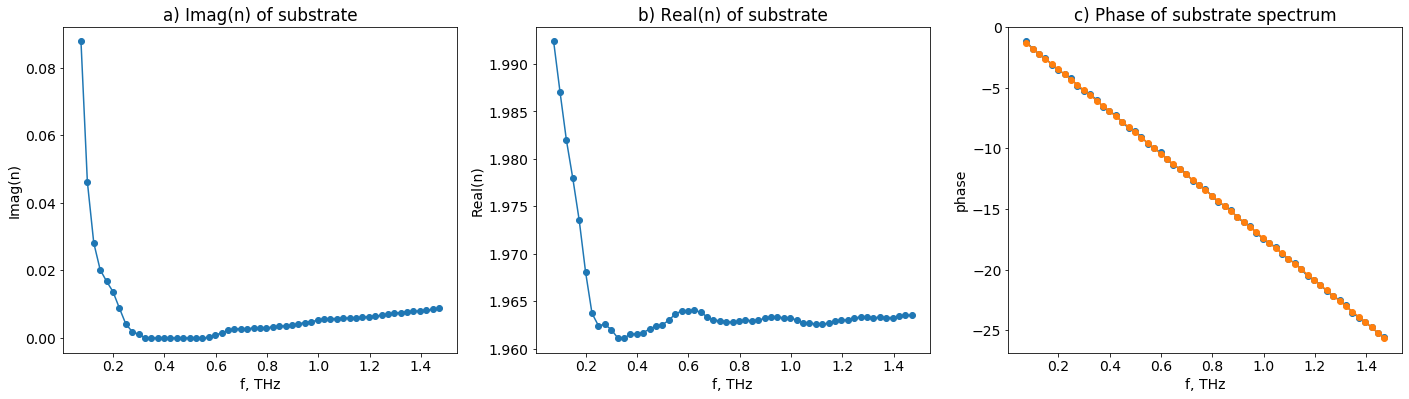

In [5]:
#counts simplified substrate's refractive index from filtered data is counted
shift = 3  #enter step, from which plots are started to be built (=1 is recommended while testing)

ph=np.zeros(border_stop);   ph_gauss=np.zeros(border_stop)
H = np.zeros(border_stop, dtype = complex);   H_gauss = np.zeros(border_stop, dtype = complex)
n_simple=np.zeros(border_stop);   k_simple=np.zeros(border_stop)
for i in range (1,border_stop):
    H[i] = signal_w[1,i]/signal_w[0,i];   H_gauss[i] = signal_w_gauss[1,i]/signal_w_gauss[0,i]
    ph[i] = cmath.phase(H[i]);   ph_gauss[i] = cmath.phase(H_gauss[i])
ph=np.unwrap(ph); ph_gauss = np.unwrap(ph_gauss)

wlc = np.zeros(border_stop)
for i in range (1,border_stop):
    wlc[i] = frequency[i]*2*math.pi*L/(3*10**8)
    
for i in range (1,border_stop):
    n_simple[i] = 1 - (ph_gauss[i])/wlc[i]
    k_simple[i] = math.log(4*n_simple[i]/((n_simple[i]+1)**2)/abs(H_gauss[i]))/wlc[i]
    if k_simple[i] < 0:
        k_simple[i] = 0.
n=np.copy(n_simple)  
k=np.zeros(border_stop)

plt.rcParams['figure.figsize'] = [24,6]

plt.subplot(1, 3, 1)
plt.plot(frequency[shift:border_stop]/10**12, k_simple[shift:border_stop], 'o-')
plt.ylabel('Imag(n)')
plt.xlabel('f, THz')
plt.title('a) Imag(n) of substrate')
plt.subplot(1, 3, 2)
plt.plot(frequency[shift:border_stop]/10**12, n_simple[shift:border_stop], 'o-')
plt.ylabel('Real(n)')
plt.xlabel('f, THz')
plt.title('b) Real(n) of substrate')
plt.subplot(1, 3, 3)
plt.plot(frequency[shift:border_stop]/10**12, ph[shift:border_stop], 'o-')
plt.plot(frequency[shift:border_stop]/10**12, ph_gauss[shift:border_stop], 'o-')
plt.ylabel('phase')
plt.xlabel('f, THz')
plt.title('c) Phase of substrate spectrum')
plt.show()

Counted 100 %
True width is 862.0 mkm, when zeta is  0.998


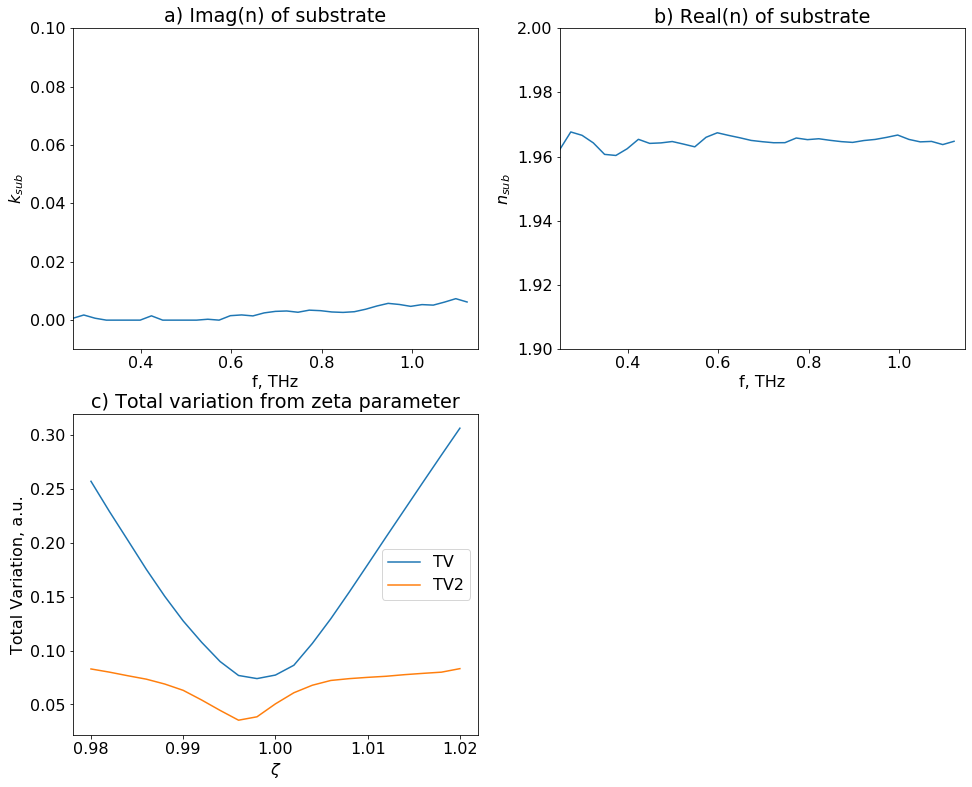

In [6]:
#counts iteratively n and k with respect to Fabri-Pero effect (eqns from Mira "Thz Metrology" pp. 44-45)
#corrects the thickness of substrate iterating over dzeta values

start = 10  #enter step, from which plots are started to be built (=1 is recommended while testing)
finish = 46  #enter step, to which plots are stopped to be built (=border_stop is recommended while testing)

H_model=np.zeros(border_stop, dtype = complex)
epsilon = 0.01
counter = 0
Total_err = 1
control=[]
zeta_ar = np.arange(0.98,1.02,0.002)   #an array of multipliers to correct the substrate's thickness
TV_ar = []
TV2_ar = []
zeta_opt = 0.
TV_min = 1000

for zeta in zeta_ar:
    for i in range (1,finish):
        wlc[i] = frequency[i]*2*math.pi*L*zeta/(3*10**8)
    n_new=np.copy(n_simple)
    k_new=np.copy(k_simple)
    ER_m=np.zeros(border_stop)
    ER_p=np.zeros(border_stop)
    counter = 0
    Total_err = 1
    while (counter < 1000) and (Total_err > epsilon):
        n=np.copy(n_new);   k=np.copy(k_new)
        for i in range (1,finish):
            n_hat = n[i] - 1.j*k[i]
            H_model[i] = 4*n_hat/(n_hat+1)**2 * cmath.exp(-1.j*(n_hat-1)*wlc[i])
            FP = 1-((1-n_hat)/(n_hat+1))**2 * cmath.exp(-2.j*n_hat*wlc[i])
            H_model[i] = H_model[i] /FP
            ER_p[i] = cmath.phase(H_model[i])
        ER_p = np.unwrap(ER_p)
        for i in range (start,finish):
            ER_p[i] = ph[i] - ER_p[i]
            ER_m[i] = abs(H[i]) - abs(H_model[i])
            n_new[i] = n[i] - epsilon*ER_p[i]
            k_new[i] = k[i] - epsilon*ER_m[i]
        Total_err = 0
        counter = counter + 1
        for i in range (start,finish):
            Total_err +=  abs(ER_p[i]) + abs(ER_m[i])
            
    TV = 0; TV2 = 0    
    for i in range (start,finish-1):
        TV += abs(k[i+1]-k[i]) + abs(n[i+1]-n[i])
    for i in range (start, finish-2):
        TV2 += abs(abs(k[i+2]-k[i+1]) + abs(n[i+2]-n[i+1]) - abs(k[i+1]-k[i]) - abs(n[i+1]-n[i]))
    if TV_min>TV:
        L_true = zeta*L
        TV_min=TV
        n_opt=np.copy(n)
        k_opt=np.copy(k)
        wlc_true = np.copy(wlc)
    TV_ar.append(TV)
    TV2_ar.append(TV2)
    percent = (zeta-zeta_ar[0])/(zeta_ar[-1]-zeta_ar[0])*100
    clear_output(wait=True)
    print("Counted", int(percent),"%")
print("True width is", np.round(L_true*10**6), "mkm, when zeta is ", np.round(L_true/L,3))

for i in range (start,finish):
    if k_opt[i] < 0:
        k_opt[i] = 0.

plt.rcParams['figure.figsize'] = [16,13]
plt.rc('font', size=16)

plt.subplot(2, 2, 1)
plt.plot(frequency[start:finish]/10**12, k_opt[start:finish], '-')
plt.ylabel('$k_{sub}$')
plt.xlabel('f, THz')
plt.axis([frequency[start]/10**12, frequency[finish]/10**12, -0.01, 0.1])   #paste display range for Imag(n)
plt.title('a) Imag(n) of substrate')
plt.subplot(2, 2, 2)
plt.plot(frequency[start:finish]/10**12, n_opt[start:finish], '-')
plt.ylabel('$n_{sub}$')
plt.xlabel('f, THz')
plt.axis([frequency[start]/10**12, frequency[finish]/10**12, 1.9, 2.])   #paste display range for Real(n)
plt.title('b) Real(n) of substrate')
plt.subplot(2, 2, 3)
plt.plot(zeta_ar, TV_ar, '-', label = 'TV')
plt.plot(zeta_ar, TV2_ar, '-', label = 'TV2')
plt.ylabel('Total Variation, a.u.')
plt.xlabel('$\zeta$')
plt.title('c) Total variation from zeta parameter')
plt.legend(loc='right')
plt.show()

Counted 100 %
Drude-Smith model parameters:
tau =  251.2 fs
sigma_DC =  3.17 mS
c =  -0.1


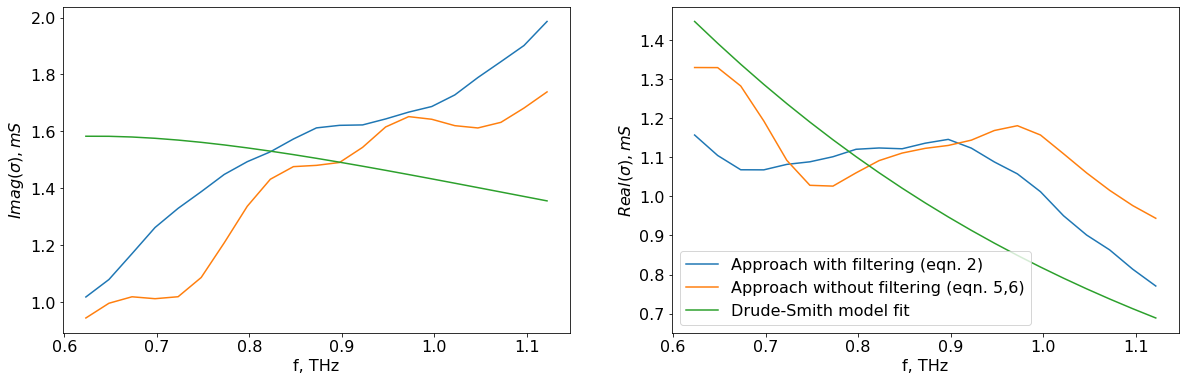

In [9]:
#Counts complex conductivity with derived accurate equation (and low-pass filtering)

start = 25  #enter step, from which plots are started to be built (=1 is recommended while testing)
finish = 46  #enter step, to which plots are stopped to be built (=border_stop is recommended while testing)
#enter below the ranges of parameters for drude fit
tau_min = 150/10**15
tau_max = 300/10**15
sigma_dc_min = 8*10**9
sigma_dc_max = 1*10**11


sigma=np.zeros(border_stop,dtype = complex)
sigma_tinkham=np.zeros(border_stop,dtype = complex)
wlc = np.copy(wlc_true)
for i in range (1,finish):
    n_hat = n_opt[i] - 1.j*k_opt[i]
    back_relative = signal_w[1,i]/signal_w[2,i]
    #counts complex conductivity with derived equation
    sigma[i] = ((n_hat+1)**2 - (n_hat-1)**2 * cmath.exp(-2.j * n_hat *wlc[i])) * (back_relative-1) / \
        ((n_hat+1)+(n_hat-1) * cmath.exp(-2.j * n_hat *wlc[i])) / 376
    #counts complex conductivity with simple Tinkham equation
    sigma_tinkham[i] = (1+n_simple[i]-1.j*k_simple[i])*(signal_w_gauss[1,i]/signal_w_gauss[2,i]-1) / 376 
    
sos = butter(6, int(T_length/6), 'lp', fs=T_length, output='sos')   #may chenge lp filter parameters
sigma_lp = sosfilt(sos, sigma)

drude = np.zeros(border_stop, dtype = complex)
minimum = 10000
#the following iterations fit experimental conductivity to Drude-Smith model end determines optimal D-S parameters
for tau in np.linspace(tau_min, tau_max,41):
    for sigma_dc in np.linspace(sigma_dc_min,sigma_dc_max,41):
        for c in np.linspace(-1.,0.,11):
            total_error = 0
            for i in range (start,finish):
                drude[i] = sigma_dc*tau/(1.-1.j*frequency[i]*2*math.pi*tau)*(1.+c/(1.-1.j*frequency[i]*2*math.pi*tau))
                total_error += abs(drude[i] - sigma_lp[i])
                #total_error += abs(drude.imag[i] - sigma_tinkham.imag[i]) + abs(drude.real[i] - sigma_tinkham.real[i])
            if total_error < minimum:
                minimum = total_error
                sigma_dc_opt, tau_opt, c_opt = sigma_dc, tau, c
    percent = (tau-tau_min)/(tau_max-tau_min)*100
    clear_output(wait=True)
    print("Counted", int(percent),"%")

print('Drude-Smith model parameters:')
print("tau = ", np.round(tau_opt*10**15,1), 'fs')
print('sigma_DC = ', np.round(sigma_dc_opt*tau_opt*1000,2), 'mS')
print('c = ', np.round(c_opt,3))

for i in range (start,finish):
    drude[i] = sigma_dc_opt*tau_opt/(1-1.j*frequency[i]*2*math.pi*tau_opt)*\
        (1+c_opt/(1+1.j*frequency[i]*2*math.pi*tau_opt))    
    
plt.rcParams['figure.figsize'] = [20,6]

plt.subplot(1, 2, 1)
plt.plot(frequency[start:finish]/10**12, sigma_tinkham.imag[start:finish]*1000, '-')
plt.plot(frequency[start:finish]/10**12,sigma_lp.imag[start:finish]*1000,'-')
plt.plot(frequency[start:finish]/10**12,drude.imag[start:finish]*1000,'-')
plt.ylabel("$Imag(\sigma),mS$")
plt.xlabel("f, THz")
plt.subplot(1, 2, 2)
plt.plot(frequency[start:finish]/10**12, sigma_tinkham.real[start:finish]*1000, '-', label = 'Approach with filtering (eqn. 2)')
plt.plot(frequency[start:finish]/10**12,sigma_lp.real[start:finish]*1000,'-', label = 'Approach without filtering (eqn. 5,6)')
plt.plot(frequency[start:finish]/10**12,drude.real[start:finish]*1000,'-', label = 'Drude-Smith model fit')
plt.ylabel("$Real(\sigma),mS$")
plt.xlabel("f, THz")
plt.legend(loc='lower left')
plt.show()